
#**Milestone 2:**
Creating a dictionary-based sentiment analyzer.


*   Word tokenization
*   Sentence tokenization
*   Scoring of the reviews
*   Comparison of the scores with the reviews in plots
*   Measuring the distribution
*   Handling negation
*   Adjusting the dictionary-based sentiment analyzer
*   Checking your results



### **Setting up the environment**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


###**Importing the required modules**

In [2]:
# importing relevant libraries
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment.util import mark_negation

nltk.download('punkt')
nltk.download('opinion_lexicon') 

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


###**Loading in the small corpus csv**

In [3]:
# importing and reading csv from drive
df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis for Marketing/Data/small_corpus.csv')

In [4]:
# viewing a sample of the data
df.head()

,ratings,reviews
0,1,Recently UBISOFT had to settle a huge class-ac...
1,1,"code didn't work, got me a refund."
2,1,"these do not work at all, all i get is static ..."
3,1,well let me start by saying that when i first ...
4,1,"Dont waste your money, you will just end up us..."


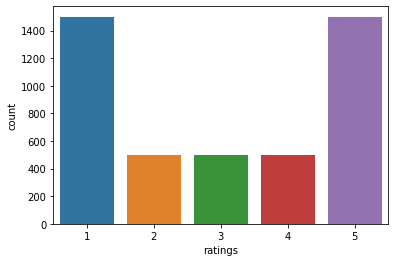

In [5]:
# plotting the data
sns.countplot(data = df, x='ratings')

In [6]:
# checking for NaN values
df[df['reviews'].isna()]

,ratings,reviews
686,1,NaN
2590,4,NaN
3197,5,NaN
3470,5,NaN


In [7]:
# filling NaNs in column reviews with string 'None'
df.reviews = df.reviews.fillna('None')

In [8]:
# checking again 
df['reviews'].notna().all()

True

In [9]:
# printing a sample rating + review
print(df.iloc[1]['ratings'])
print(df.iloc[1]['reviews'])

1
code didn't work, got me a refund.


In [10]:
# checking review length
reviews_list = df['reviews'].tolist()
for index, review in enumerate(reviews_list[:16]):
    print(f'Index: {index} Length: {len(review)}')

length = [len(x) for x in reviews_list]
print('\nmin', np.min(length))
print('mean', np.mean(length))
print('std', np.std(length))
print('max', np.max(length))

Index: 0 Length: 2925
Index: 1 Length: 34
Index: 2 Length: 101
Index: 3 Length: 2844
Index: 4 Length: 271
Index: 5 Length: 76
Index: 6 Length: 2050
Index: 7 Length: 30
Index: 8 Length: 421
Index: 9 Length: 174
Index: 10 Length: 621
Index: 11 Length: 259
Index: 12 Length: 235
Index: 13 Length: 403
Index: 14 Length: 242
Index: 15 Length: 7865

min 1
mean 747.2044444444444
std 1359.0030402967473
max 26713


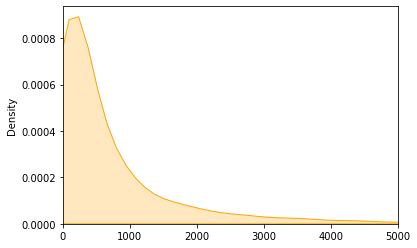

In [11]:
# plot review length distribution
reviews_list = df['reviews'].tolist()
plt.xlim(0, 5000)
p = sns.kdeplot(length, shade=True, color='orange')

###**Tokenizing words and sentences** 

In [12]:
# lower case and tokenizing words
word_tokenization = df['reviews'].str.lower().apply(lambda x: word_tokenize(x))
word_tokenization

0       [recently, ubisoft, had, to, settle, a, huge, ...
1        [code, did, n't, work, ,, got, me, a, refund, .]
2       [these, do, not, work, at, all, ,, all, i, get...
3       [well, let, me, start, by, saying, that, when,...
4       [dont, waste, your, money, ,, you, will, just,...
                              ...                        
4495    [nice, long, micro, usb, cable, ,, battery, la...
4496    [i, 've, been, having, a, great, time, with, t...
4497                                                  [d]
4498    [really, pretty, ,, funny, ,, interesting, gam...
4499    [i, had, a, lot, of, fun, playing, this, game,...
Name: reviews, Length: 4500, dtype: object

In [13]:
# lower case and tokenizing sentences
sent_tokenization = df['reviews'].str.lower().apply(lambda x: sent_tokenize(x))
sent_tokenization

0       [recently ubisoft had to settle a huge class-a...
1                    [code didn't work, got me a refund.]
2       [these do not work at all, all i get is static...
3       [well let me start by saying that when i first...
4       [dont waste your money, you will just end up u...
                              ...                        
4495    [nice long micro usb cable, battery lasts a lo...
4496    [i've been having a great time with this game....
4497                                                  [d]
4498    [really pretty, funny, interesting game., work...
4499    [i had a lot of fun playing this game, if your...
Name: reviews, Length: 4500, dtype: object

###**Using the NLTK opinion lexicon**

In [14]:
# exploring the content
print(f'Total lexicon words: {len(opinion_lexicon.words())}')
print(f'Total positive words: {len(opinion_lexicon.positive())}')
print(f'Total negative words: {len(opinion_lexicon.negative())}')

print(f'\nThese are positive examples: {opinion_lexicon.positive()[:5]}')
print(f'These are negative examples: {opinion_lexicon.negative()[:5]}')

# creating variables for classification:
positive = set(opinion_lexicon.positive())
negative = set(opinion_lexicon.negative())

Total lexicon words: 6789
Total positive words: 2006
Total negative words: 4783

These are positive examples: ['a+', 'abound', 'abounds', 'abundance', 'abundant']
These are negative examples: ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']


###**Classifying positive (+1) and negative (-1) reviews**

In [15]:
# 2-STEP-PROCESS:
# 1] scoring a sentence based on the sum of positive/negative words

def score_per_sentence(sentence):
  '''
  input: 
    sentence: a sentence of the reviews
  output:
    score: score of the sentence between -1 and 1
  '''
  sentence = [s.lower() for s in sentence if s.isalnum()]
  total = len(sentence)
  total_pos = len([p for p in sentence if p in positive])
  total_neg = len([n for n in sentence if n in negative])
  sentiment = total_pos - total_neg
  
  if total > 0:
    return sentiment/total
  else:
    return 0

In [16]:
# 2] slicing reviews into sentences and calculating the total score by summing up the sentence scores

def score_review(review):
  '''
  input:
    review: single review with one or multiple sentences
  output:
    score: score of the selected review
  '''
  scores = []
  sentences = sent_tokenize(review)
  for s in sentences:
    words = word_tokenize(s)
    score = score_per_sentence(words)
    scores.append(score)
  
  if len(words) > 0:
    return sum(scores)/len(scores)
  else:
    return 0

In [17]:
# applying the functions to a subset of reviews
review_sentiments = [score_review(r) for r in reviews_list[:10]]
print(review_sentiments[0])

-0.013158071747989037


In [18]:
# adding the scores as a new column to the DataFrame
df['sentiment_score'] = df['reviews'].apply(lambda x: score_review(x))
df.head(10)

,ratings,reviews,sentiment_score
0,1,Recently UBISOFT had to settle a huge class-ac...,-0.013158
1,1,"code didn't work, got me a refund.",0.285714
2,1,"these do not work at all, all i get is static ...",0.000000
3,1,well let me start by saying that when i first ...,-0.020521
4,1,"Dont waste your money, you will just end up us...",0.000000
5,1,i ordered this and said it was tested and work...,0.117647
6,1,"UPDATE, 2010: This review is pretty old, and ...",-0.057944
7,1,I WISH I COULD GET RID OF IT!!,0.000000
8,1,What in the hell is this i can say that some o...,0.033333
9,1,Could be a lot better with different surface m...,-0.017076
